## **`TP2`**

Este Script predice sucesos a partir de la base de datos provista.
El enunciado se encuentra en el archivo Readme.md

Este archivo contiene el script que mejor performo de los analizados. 
El detalle de todo lo analizado previamente se puede visualizar en el archivo TP2_Miguel.jpynb

Importamos las librarias que preciso para un analisis preliminar del dataset.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Ingestamos el primer dataset (con el realizaremos el modelo)

In [53]:
data = pd.read_excel('E-Commerce_train.xlsx')

Realizamos un Analisis y Exploracion de los datos contenidos en este dataset:

In [54]:
data.shape  # Identificamos el tamano

(8999, 12)

In [55]:
data.head(5) # Listamos las 5 primeras filas para visualizar el dataset

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [43]:
data[data.duplicated()]  #Analizamos si hay duplicados

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


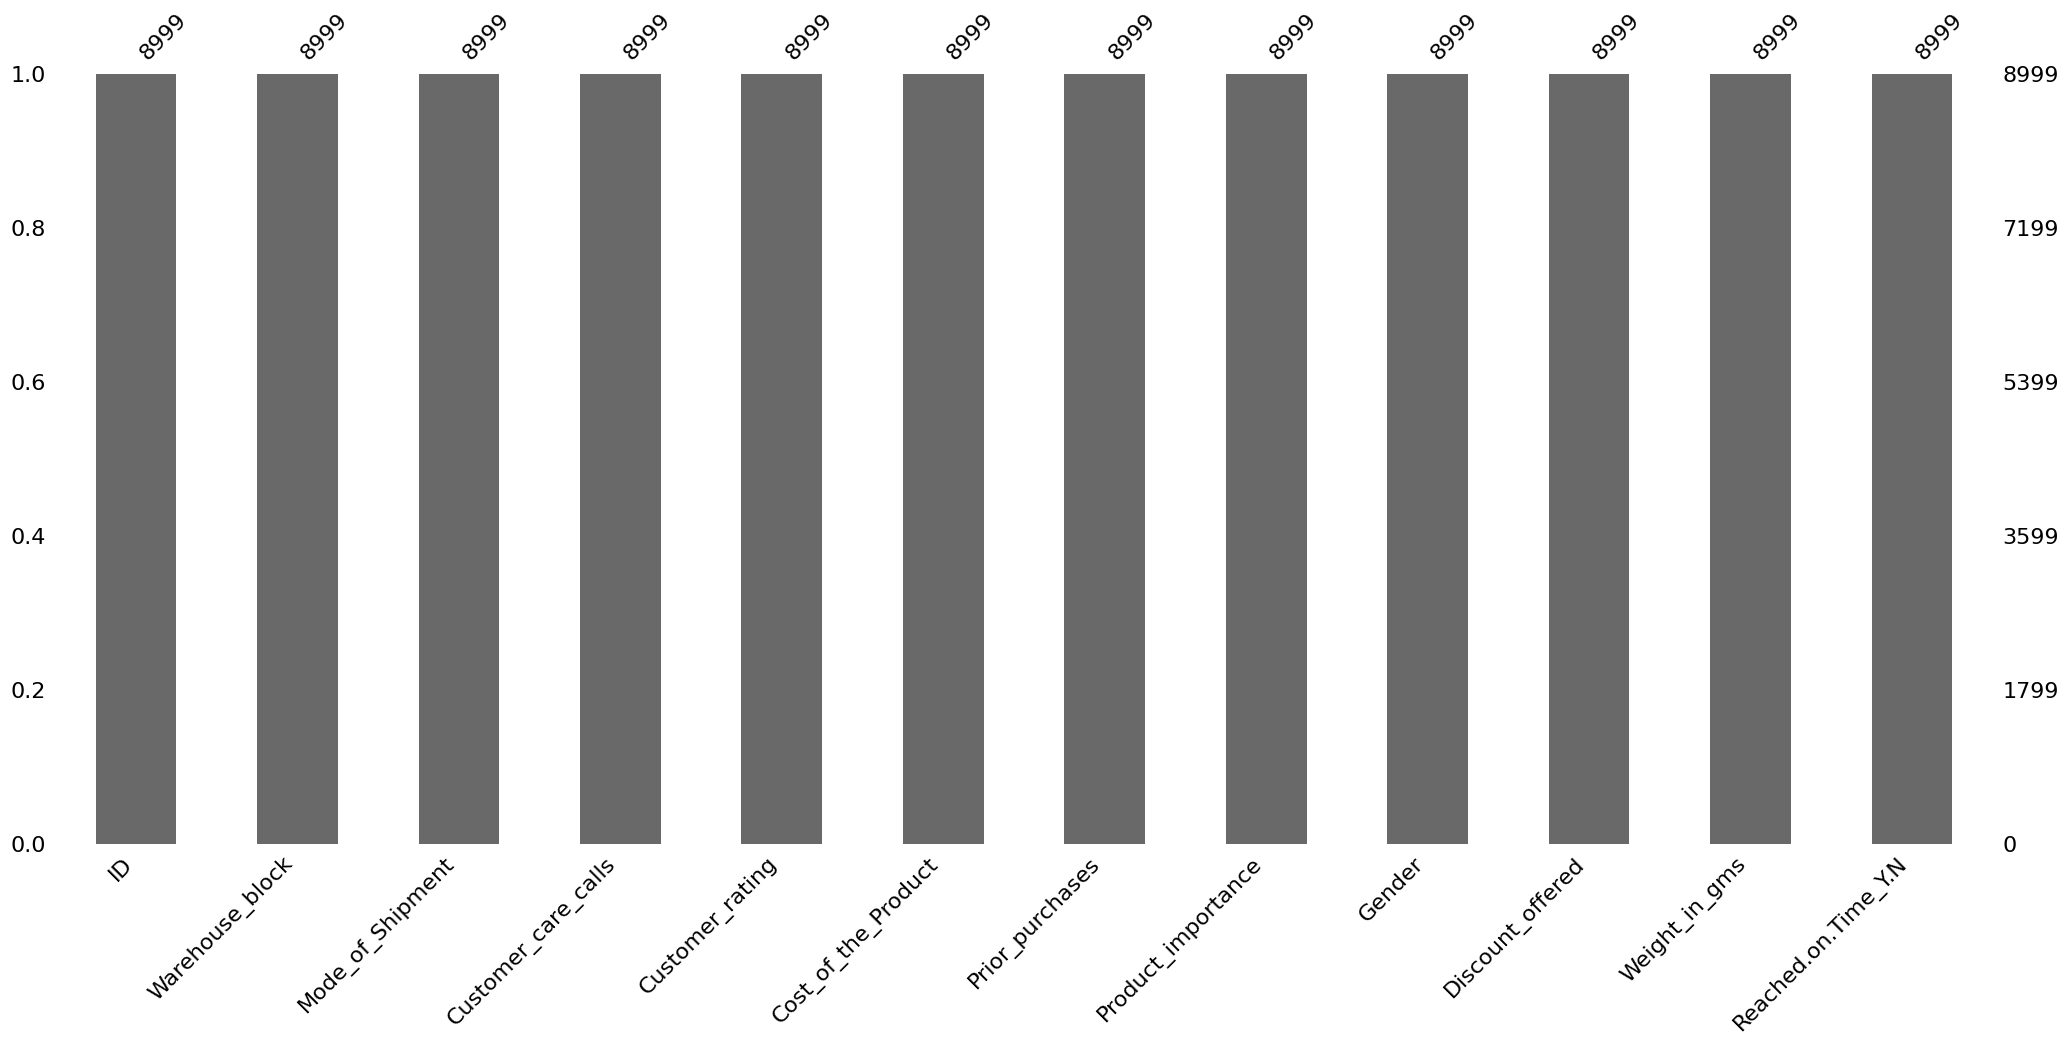

In [44]:
import missingno as msno
msno.bar(data)  
plt.show()  # Verificamos graficamente que no hay espacios vacios

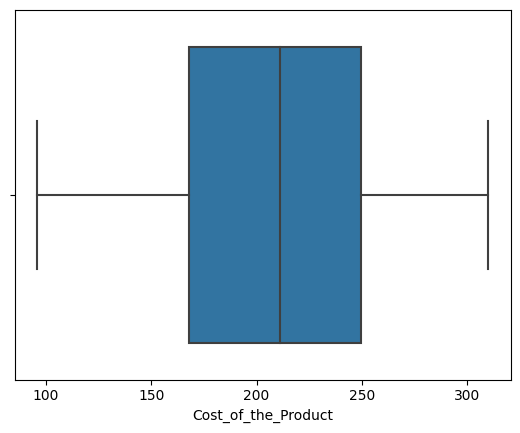

In [45]:
sns.boxplot(x = 'Cost_of_the_Product', data = data) # Buscamos graficamente valores atipicos
plt.show()

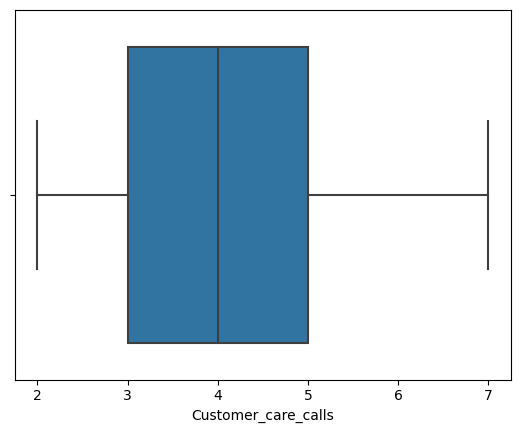

In [46]:
sns.boxplot(x = 'Customer_care_calls', data = data) # Lo mismo para otra columna
plt.show()

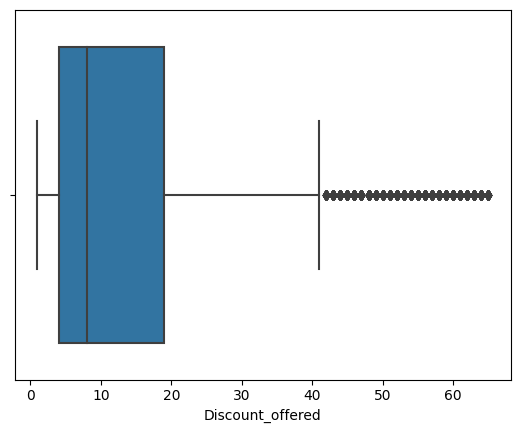

In [19]:
sns.boxplot(x = 'Discount_offered', data = data)
plt.show() # Estos datos llaman la atencion a priori, el nivel de descuentos tan alto.(parecerian outliers)

*Aparenta que la columna de descuento tiene outliers, utilizo la tecnica del rango intercuartiles, pero solo para la parte superior al 75%, Ya que tiene logica descuentos en el primer cuartil:

In [50]:
Q1 = data['Discount_offered'].quantile(0.00) # cero porque en realidad descuentos inferiores a 25 estarian bien.
Q3 = data['Discount_offered'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
print("Serian outliers con este metodo los mayores a: ",BS)
print('Cantidad de registros totales:', data.shape[0])
print('Cantidad de outliers:', data[(data['Discount_offered']<BI) | (data['Discount_offered']>BS)].shape[0] )

Serian outliers con este metodo los mayores a:  46.0
Cantidad de registros totales: 8999
Cantidad de outliers: 938


De este analisis, se desprende que podriamos elimiar los 938 registros con descuento mayor a 46% pero... si eliminamos los outliers, podriamos perder info que no sabemos a priori si esta corralacionada con las demoras en la entrega y ademas el enunciado dice hasta 65%, verifco si se pasa de 65:

In [ ]:
print(np.where(data['Discount_offered']>65))

No hay ninguno mayor a 65. Asi que a priori no eliminamos ningun dato.

In [60]:
# Renombramos la ultima columna sacando los puntos:
data=data.rename({'Reached.on.Time_Y.N':'Reached_on_Time'}, axis=1)

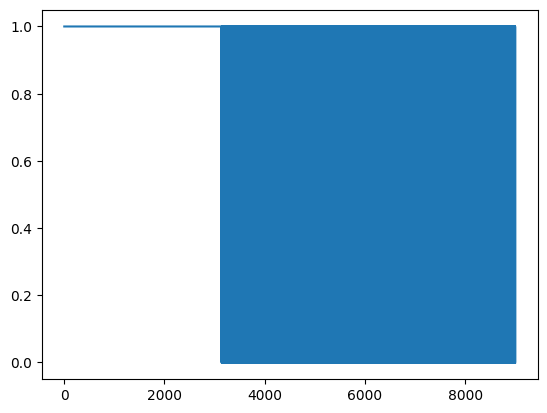

In [48]:
plt.plot(data["ID"],data["Reached_on_Time"]) # Aca se evidencia que los primeros 3000 ID tienen 1 cono salida.

In [49]:
data.dtypes

ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached_on_Time         int64
dtype: object

In [57]:
# Detectamos 4 columnas con valores alfanumericos, usaremos LabelEncoder para darle valor numerico
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Product_importance'] = label_encoder.fit_transform(data['Product_importance'])
data["Warehouse_block"]= label_encoder.fit_transform(data['Warehouse_block'])
data['Mode_of_Shipment']=label_encoder.fit_transform(data['Mode_of_Shipment'])
data['Gender']=label_encoder.fit_transform(data['Gender'])

Resumiendo: Del analisis exploratorio, determinamos estos dos posibles sesgos para el modelo que apliquemos.
 1. Los envios con descuento mayor a 10% que todos se identifican como entregados.
 2. Los datos desde el index 1 hasta el 3135 que todos se identifican como entregados.
 
Esto lo consideraremos para evaluar el modelo de prediccion. 

<AxesSubplot: >

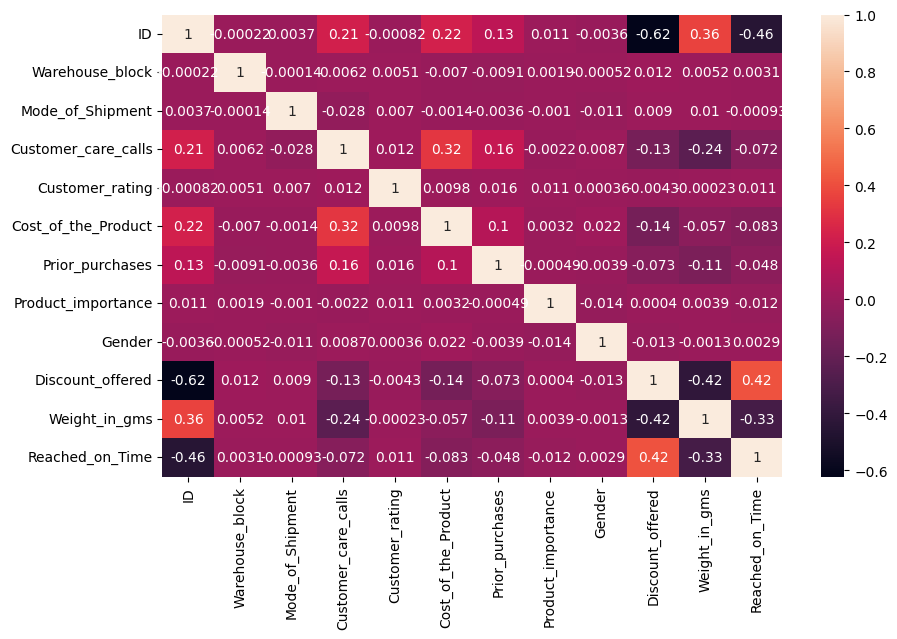

In [24]:
# Importo libreria para graficar
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# Usamos el heatmap para ver las relaciones entre las variables
sns.heatmap(data.corr(), ax=ax, annot=True)

Ahora eliminamos las filas que no estan relacionadas

In [58]:
data=data.drop(["ID","Warehouse_block","Gender","Mode_of_Shipment","Customer_rating","Product_importance"] , axis=1)

In [61]:
# Voy a verificar si esta balanceado el valor a predecir Reached_on_Time
data['Reached_on_Time'].value_counts()

1    5719
0    3280
Name: Reached_on_Time, dtype: int64

Vemos que 5719 registros indican que No llego a tiempo (salida 1) y 3280 que No llegaron a tiempo (salida 0)

<function matplotlib.pyplot.show(close=None, block=None)>

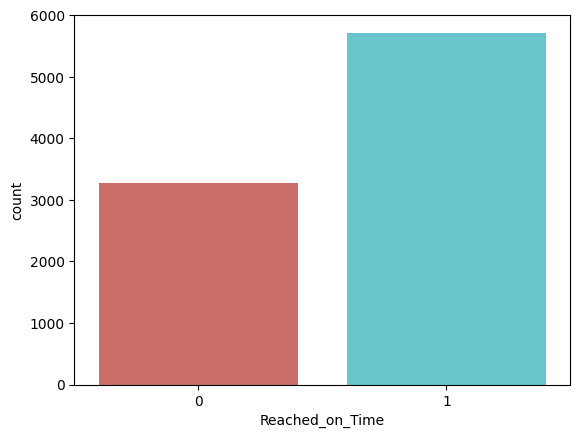

In [51]:
# Graficamente se evidencia el desbalanceo
sns.countplot(x='Reached_on_Time', data=data, palette='hls')
plt.show

Vamos a Balancearlo para luego analizar los modelos predictivos, con la tecnica SMOTE oversampling tomaremos en forma aleatoria datos que contenan igual cantidad de 0 y 1 para la salida Reached_on_Time. Usando la libraria imbalanced-learned. El metodo lo tome de este video: https://www.youtube.com/watch?v=_bm2gPdAbS8

In [62]:
from sklearn import preprocessing # Usamos libreria sklearn, funcion split para dividir el dataset
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
X=data.loc[:,data.columns != 'Reached_on_Time']
y=data.loc[:,data.columns == 'Reached_on_Time']

from imblearn.over_sampling import SMOTE
os=SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split (X ,y , test_size=0.30, random_state=7) # test_size se 
# recomienda entre 25% y 35%, probe con las 3 alternativas y 30 es la de mejor recall score
os_data_X, os_data_y = os.fit_resample (X_train, y_train)

#Aca verificamos los datos de nuestra data
print ('Tamaño original del dataset', len(data))
print ('Tamaño del upsampled dataset' , len(os_data_X) )
print ('No llegaron a tiempo en el upsampled data es', len (os_data_y[os_data_y["Reached_on_Time"]==0]))
print ('Si llegaron a tiempo en el upsampled  data es', len (os_data_y[os_data_y["Reached_on_Time"]==1]))

Tamaño original del dataset 8999
Tamaño del upsampled dataset 8054
No llegaron a tiempo en el upsampled data es 4027
Si llegaron a tiempo en el upsampled  data es 4027


<function matplotlib.pyplot.show(close=None, block=None)>

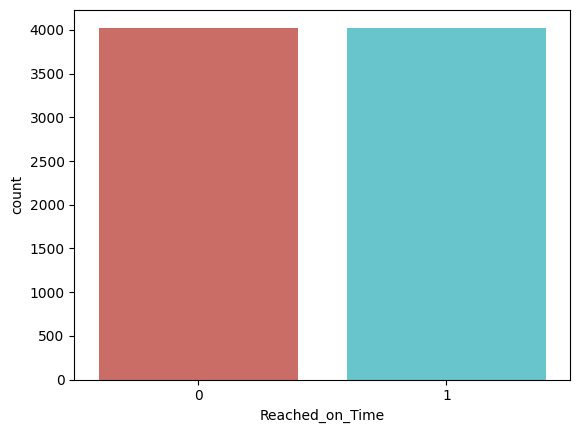

In [28]:
# Verificacion grafica del balanceo
sns.countplot(x='Reached_on_Time', data=os_data_y, palette='hls')
plt.show

In [29]:
# Verifico los formatos antes de aplicar el modelo.
print("shape X del dataset oversampled",os_data_X.shape)
print("shape y del dataset oversampled",os_data_y.shape)
print("shape X para entrenamiento", X_train.shape)
print("shape X para testeo       ", X_test.shape)
print("shape y para entrenamiento", y_train.shape)
print("shape y para testeo       ", y_test.shape)

shape X del dataset oversampled (8054, 5)
shape y del dataset oversampled (8054, 1)
shape X para entrenamiento (6299, 5)
shape X para testeo        (2700, 5)
shape y para entrenamiento (6299, 1)
shape y para testeo        (2700, 1)


Aplicamos el modelo de Regresion Logistica

In [30]:
from sklearn.linear_model import LogisticRegression
modelo1=LogisticRegression()
modelo1.fit(X_train,y_train)

LogisticRegression()

In [31]:
# Importamos una métrica utilizada para evaluar modelos de clasificación. 
from sklearn.metrics import accuracy_score 
# Predecimos sobre el dataset de entrenamiento balanceado
y_pred = modelo1.predict(X_test)
# Evaluamos
print('El score accurancy del modelo es:', accuracy_score(y_test, y_pred))

El score accurancy del modelo es: 0.6662962962962963


In [32]:
# Calculamos el recall
from sklearn.metrics import recall_score
print('El recall del modelo es:', recall_score(y_test, y_pred))

El recall del modelo es: 0.766548463356974


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred )) 

              precision    recall  f1-score   support

           0       0.56      0.50      0.53      1008
           1       0.72      0.77      0.74      1692

    accuracy                           0.67      2700
   macro avg       0.64      0.63      0.63      2700
weighted avg       0.66      0.67      0.66      2700



Hemos verificado que el modelo posee un buen recall y precision para los 1 (llego a tiempo) y aceptable para los 0 (no llego a tiempo)

In [34]:
# Calculamos la matriz de confusion
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[ 502  506]
 [ 395 1297]]


Ahora vamos a realizar el testeo del modelo sobre el dataset de prueba, realizandole la misma Normalizacion que al set de entrenamiento.

In [35]:
data_test = pd.read_excel('E-Commerce_test.xlsx', index_col=0)

In [36]:
data_test=data_test.drop(["Warehouse_block","Gender","Mode_of_Shipment","Customer_rating","Product_importance"], axis=1)

In [37]:
y_pred_test = modelo1.predict(data_test) # Aplicamos el modelo

In [38]:
# Convertimos el array a Dataset para ponerle el titulo "pred" solicitado
Respuesta1=pd.DataFrame(y_pred_test, columns=["pred"])

In [39]:
# Exportamos la respuesta formato csv para enviarla, eliminando el indice
Respuesta1.to_csv('mav.csv', index=False)